# Singapore hospitality analysis

## Author: Ankur Shanker

## Student ID: 21159916

### **Section 1:** Importing packages necessary for workbook execution.

Libraries necessary for workbook execution related to functionality responsible for geo-spatial data reading, plotting, and statistical analysis need to be imported in order for this workbook to function.

In [1]:
# Import packages required for analysis
import pandas as pd
from sklearn.model_selection import train_test_split
import rfpimp
from sklearn import model_selection

# Import packages required for numeric operations
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [2]:
# Import packages required for geospatial analysis
import geopandas as gpd
import pyproj
import geopy.distance
pyproj.datadir.get_data_dir()

'C:\\Users\\ankur\\AppData\\Roaming\\jupyterlab-desktop\\jlab_server\\Library\\share\\proj'

In [3]:
# Import packages required for data visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
sn.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

### **Section 2:** Reading and formatting data

Data related to the hospitality industry of Singapore (open source) is read in and interepreated below.

In [5]:
singapore_hotels = pd.read_csv('Data/Singapore data/Singapore hospitality.csv')
singapore_hotels.columns

Index(['Unnamed: 0', 'Name', 'Price', 'Closest distance to Marina Bay Sands',
       'Closest distance to Resorts World Casino Sentosa', 'geometry',
       'Traffic lights within 500 meters', 'Parking lots within 500 meters'],
      dtype='object')

In [6]:
singapore_hotels = singapore_hotels[['Price', 'Closest distance to Marina Bay Sands',
       'Closest distance to Resorts World Casino Sentosa', 'geometry',
       'Traffic lights within 500 meters', 'Parking lots within 500 meters']]

### **Section 2:** Regression

The final step of the analysis presented in this workbook involves determining the dependent and independent variables that will be utilised in the regression analysis. 

A process that will involve the consideration of Variance Inflation Factors and the nature of the distribution of each independent variable, in order to determine the exsitance or lack thereof a linear relationship.

Frequency distribution histograms will also be produced for each indepdendent variable in order to check for the necessity of log transformations.

If a Variance Inflation Factor score is determined to be excessive a variable is removed, likewise the existance of a non-normal frequency distribution will involve the utilisation of a log transformation for an independent variable.

First the columns that exist within the dataframe that is created above can be highlighted as follows.

Following this, dependent and independent variables can be extracted.

In [7]:
independent_variables = singapore_hotels[['Closest distance to Resorts World Casino Sentosa', 'Parking lots within 500 meters' ,'Traffic lights within 500 meters']]
dependent_variable = singapore_hotels['Price']

A logarithmic version of each independent variable is added to the dataframe below.

In [8]:
singapore_hotels_copy = singapore_hotels

In [9]:
for tag in independent_variables.columns:
    if(tag != 'index'):
        variable = singapore_hotels_copy[tag]
        log_variable = np.log(variable)
        newName = 'log '+ tag
        singapore_hotels_copy[newName] = log_variable
print(singapore_hotels_copy.columns)
print(len(singapore_hotels_copy))

Index(['Price', 'Closest distance to Marina Bay Sands',
       'Closest distance to Resorts World Casino Sentosa', 'geometry',
       'Traffic lights within 500 meters', 'Parking lots within 500 meters',
       'log Closest distance to Resorts World Casino Sentosa',
       'log Parking lots within 500 meters',
       'log Traffic lights within 500 meters'],
      dtype='object')
180


c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


A visual representation of the frequency distribution of values for each variable is highlighted below using the generate graph function.

In [10]:
def generateGraph(variable, variable_tag, counts):
    try:
        ax = plt.gca()
        ax.hist(variable)
        ax.set_xlabel(variable_tag)
        ax.set_ylabel('Count')
        ax.set_title(variable_tag+" vs "+ 'Count')
        plt.show()
    except:
        print()

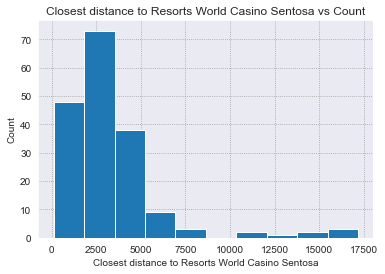

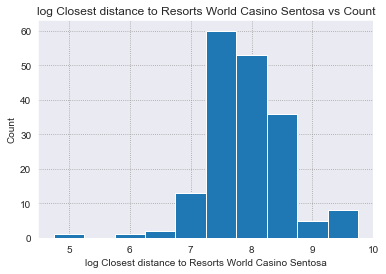

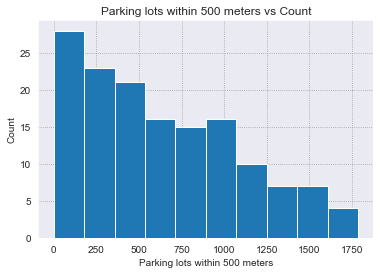

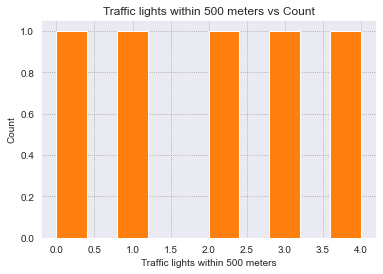

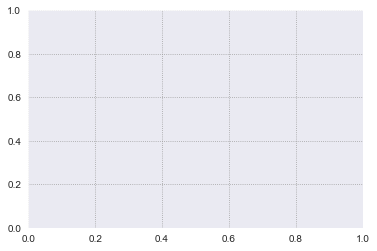

In [11]:
for tag in independent_variables.columns:
    if(tag!='index'):
        variable = singapore_hotels_copy[tag]
        value_by_count = variable.value_counts().to_dict()
        generateGraph(list(value_by_count.keys()), tag, list(value_by_count.values()))

        log_tag = 'log '+ tag
        log_variable = singapore_hotels_copy[log_tag]
        value_by_count = log_variable.value_counts().to_dict()
        generateGraph(list(value_by_count.keys()), log_tag, list(value_by_count.values()))

As can be observed log transformations have no substantial impact on the frequency distribution histograms of the independent variables and are hence unnecesarry.

Columns can now be iteratively dropped based on their Variance Inflation Factor scores in order to prevent further regression analysis from being affected by multicolliearity.

The following function is from Quantitative Methods tutorial 4 (CASA0007).

It calculates the VIF score of each independent variable and returns a dataframe containing independent variables that have a VIF score that is below 10

Source: https://moodle.ucl.ac.uk/pluginfile.php/3532739/mod_resource/content/6/Practical_advanced_regression_UPDATED.ipynb

In [12]:
def drop_column_using_vif_(df, thresh=10):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF.
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
                            for i in range(df_with_const.shape[1])],
                           name="VIF",
                           index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed.
        # This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns=index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

The utilisation of the above function removes the following variables from subsequent consideration in regression analysis.

In [13]:
independent_variables_vif = drop_column_using_vif_(independent_variables)

Finally, ordinary least squares linear regression is performed.

In [14]:
stats = sm.OLS(endog=dependent_variable, exog=independent_variables_vif).fit()
stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.315
Model:                            OLS   Adj. R-squared (uncentered):              0.304
Method:                 Least Squares   F-statistic:                              27.17
Date:                Mon, 22 Aug 2022   Prob (F-statistic):                    1.68e-14
Time:                        00:13:40   Log-Likelihood:                         -1199.2
No. Observations:                 180   AIC:                                      2404.
Df Residuals:                     177   BIC:                                      2414.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Closest distance to Resorts World Casino Sentosa     0.0196      0.004      5.253      0.000       0.012       0.027
Parking lots within 500 meters                       0.0663      0.024      2.748      0.007       0.019       0.114
Traffic lights within 500 meters                    21.5584     14.883      1.449      0.149      -7.812      50.929
==============================================================================
Omnibus:                      112.878   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              757.242
Skew:                           2.344   Prob(JB):                    3.69e-165
Kurtosis:                      11.888   Cond. No.                     4.58e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""